In [1]:
import numpy as np
from astropy import units
from astropy.io import fits
from astropy.table import Table, vstack
import pyccl as ccl
import healpy as hp
import sacc
import pymaster as nmt
import copy

from matplotlib import pyplot as plt

In [2]:
nside = 1024
npix = hp.nside2npix(nside)

In [3]:
def get_Nmap(cat_list, pixmask, nside=1024, doplot=False, title=None, usenan=False):
    
    cat_total = Table()
    
    for cat_fname in cat_list:
        cat = Table.read(cat_fname)
        cat_total = vstack([cat_total, cat])
    
    cat_total = cat_total[
                          (cat_total['PHOTOZ_3DINFER'] >= 0.0) &
                          (cat_total['PHOTOZ_3DINFER'] < 0.30)
                          ]
    
    ipix = hp.ang2pix(nside, cat_total['RA'], cat_total['DEC'], lonlat=True)
    
    Nmap = np.bincount(ipix, minlength=npix)
    Nmap = np.asarray(Nmap, dtype=float)
    
    if usenan:
        Nmap[~pixmask] = np.nan
    
    if doplot:
        hp.mollview(Nmap, title=title)
    
    return Nmap

In [4]:
def get_deltamap(Nmap,
                 #completeness, stars, mask,
                 #comp_cut=0.95, star_cut=8515, mask_cut=0,
                 pixmask,
                 mask,
                 doplot=False, title=None, usenan=False):
    
    Nmean = np.sum(Nmap[pixmask]) / np.sum(completeness[pixmask])
    
    deltamap = np.zeros_like(Nmap, dtype=float)
    
    deltamap[mask > 0] = Nmap[mask > 0] / (Nmean * completeness[mask > 0]) - 1
    
    if usenan:
        deltamap[~pixmask] = np.nan
    
    if doplot:
        hp.mollview(deltamap, title=title)
    
    return deltamap
    

In [5]:
def get_stellar_correction(deltamap, stars, mask, nbins=14):
    
    star_bins = np.linspace(np.log10(stars[mask > 0].min()),
                            np.log10(stars[mask > 0].max()),
                            nbins+1)

    bmid = 0.5*(star_bins[1:] + star_bins[:-1])
    
    mean_delta = np.zeros(nbins)
    std_delta = np.zeros(nbins)

    star_bindx = np.digitize(np.log10(stars[mask > 0]), star_bins)

    for sbin in np.arange(1,nbins+1):
        mean_delta[sbin - 1] = np.nanmean(deltamap[mask > 0][star_bindx == sbin])
        delta_npix = np.sum(star_bindx == sbin)
        std_delta[sbin - 1] = np.std(deltamap[mask > 0][star_bindx == sbin]) / np.sqrt(delta_npix)
        
    
    return mean_delta, std_delta, bmid

## Fiducial mask

In [6]:
mask = hp.read_map('./data/Legacy_footprint_final_mask.fits')
mask = hp.ud_grade(mask, nside_out=nside)

In [7]:
completeness = hp.read_map('./data/Legacy_footprint_completeness_mask_128.fits')
completeness = hp.ud_grade(completeness, nside_out=nside)

In [8]:
stars = hp.read_map('./data/allwise_total_rot_1024.fits')
stars = hp.ud_grade(stars, nside_out=nside, power=-2)

# Convert to stars per deg^2
pix_srad = 4*np.pi/npix
pix_deg2 = pix_srad*(180/np.pi)**2
stars /= pix_deg2

In [9]:
pixmask = (completeness > 0.95) * (stars < 8515) * (mask > 0)

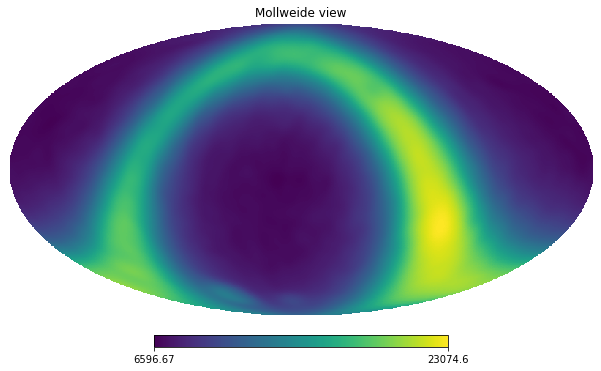

In [10]:
hp.mollview(stars)

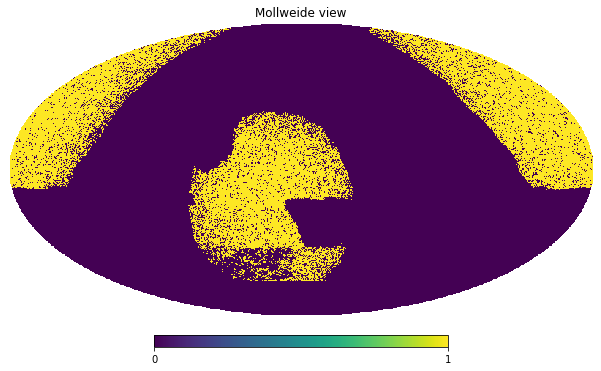

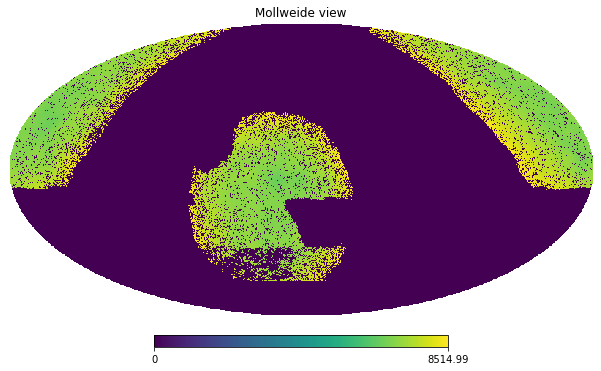

In [11]:
hp.mollview(pixmask)
hp.mollview(pixmask*stars)

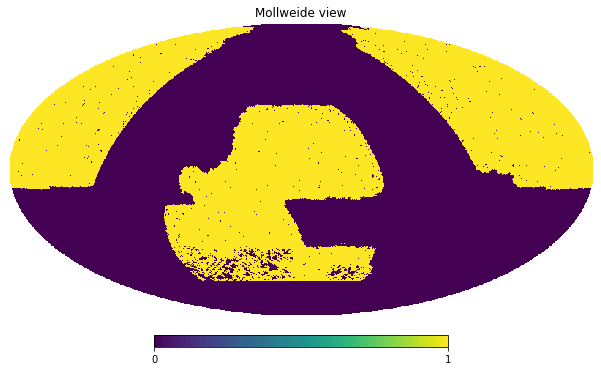

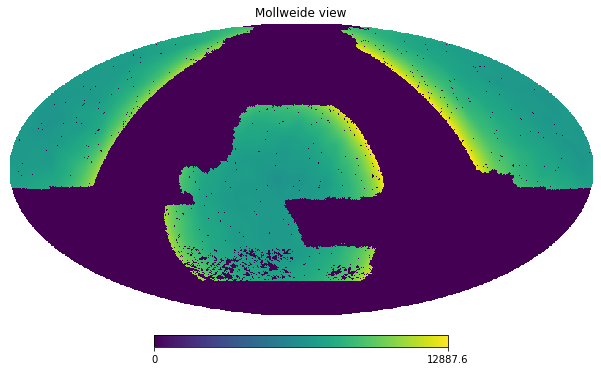

In [12]:
hp.mollview(mask)
hp.mollview(mask*stars)

In [13]:
ra, dec = hp.pix2ang(nside, np.arange(npix), lonlat=True)

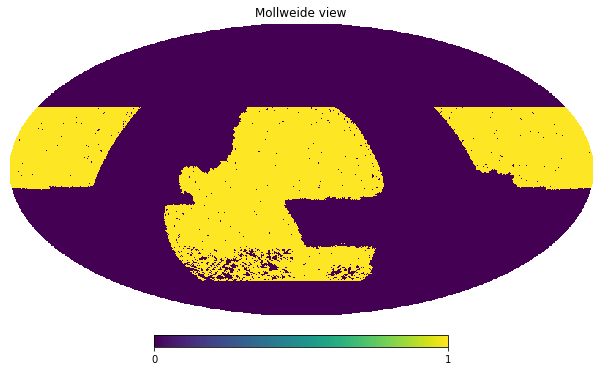

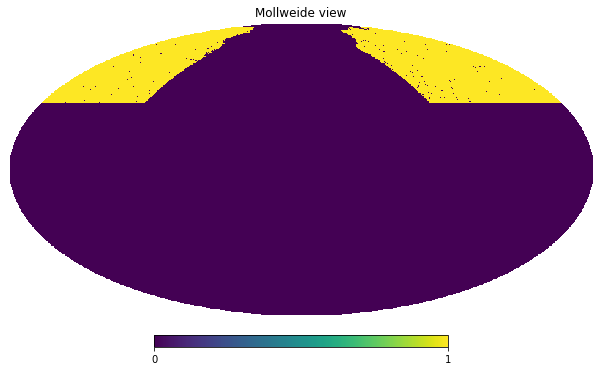

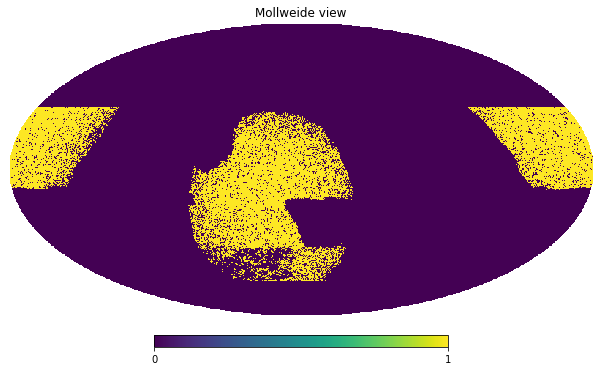

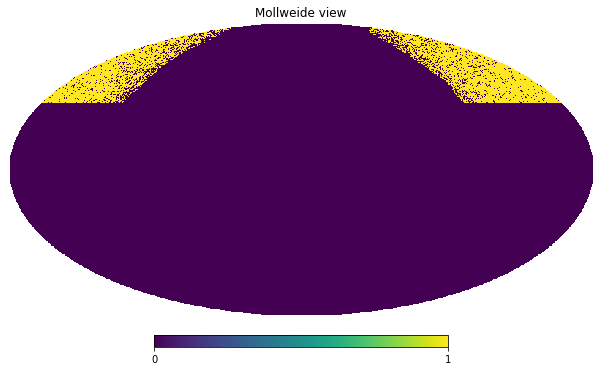

In [14]:
decals_mask = copy.copy(mask)
decals_mask[dec >= 32] = 0

bass_mzls_mask = copy.copy(mask)
bass_mzls_mask[dec <= 34] = 0

decals_pixmask = decals_mask * pixmask
bass_mzls_pixmask = bass_mzls_mask * pixmask

hp.mollview(decals_mask)
hp.mollview(bass_mzls_mask)
hp.mollview(decals_pixmask)
hp.mollview(bass_mzls_pixmask)

decals_pixmask = np.asarray(decals_pixmask, dtype=bool)
bass_mzls_pixmask = np.asarray(bass_mzls_pixmask, dtype=bool)

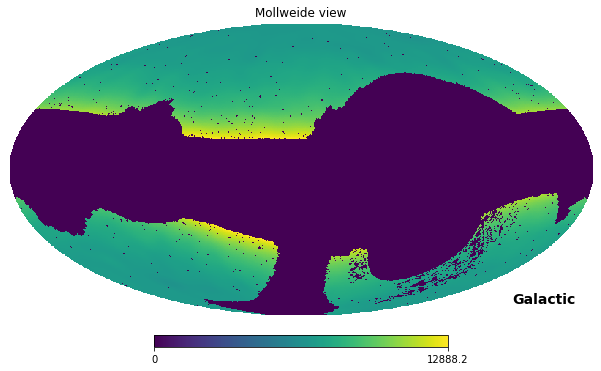

In [15]:
hp.mollview(mask*stars, coord='EG')

In [16]:
decals_apmask = nmt.mask_apodization(decals_mask,
                                      1., apotype="Smooth")

bass_mzls_apmask = nmt.mask_apodization(bass_mzls_mask,
                                      1., apotype="Smooth")

In [17]:
apmask = nmt.mask_apodization(mask,
                              1., apotype="Smooth")

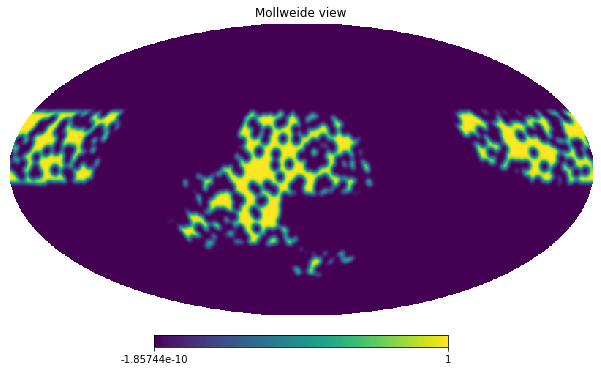

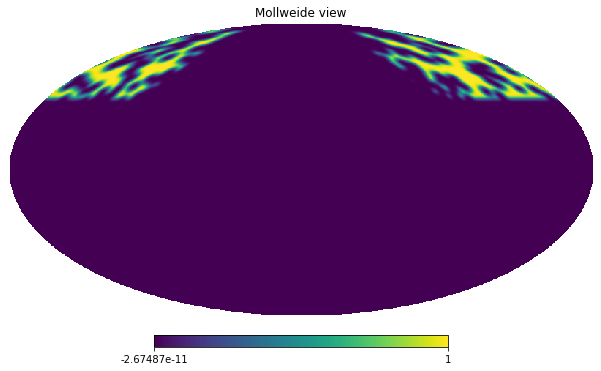

In [18]:
hp.mollview(decals_apmask)
hp.mollview(bass_mzls_apmask)

## BASS MZLS only

/Users/ianharrison/opt/anaconda3/envs/pyccl/lib/python3.9/site-packages/healpy/pixelfunc.py:482: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)


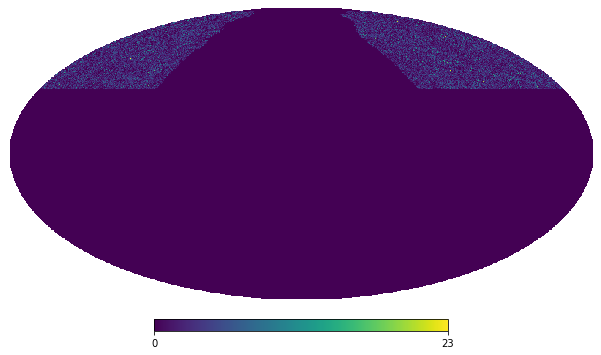

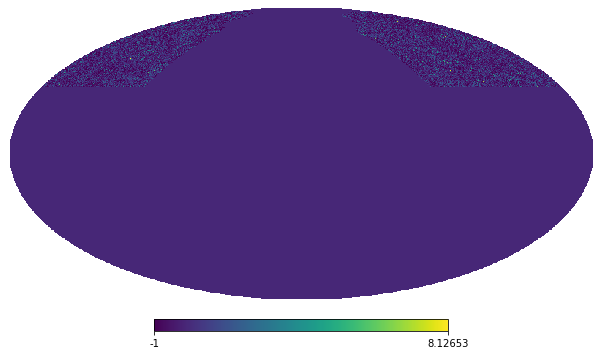

In [19]:
Nmap_bass_mzls = get_Nmap(['./data/Legacy_Survey_BASS-MZLS_galaxies-selection.fits'], bass_mzls_pixmask, nside=nside, doplot=True)
deltamap_bass_mzls = get_deltamap(Nmap_bass_mzls, bass_mzls_pixmask, bass_mzls_mask, doplot=True)

In [20]:
delta_mean_bass_mzls, delta_std_bass_mzls, star_bins_bass_mzls = get_stellar_correction(deltamap_bass_mzls, stars, np.asarray(mask, dtype=bool))

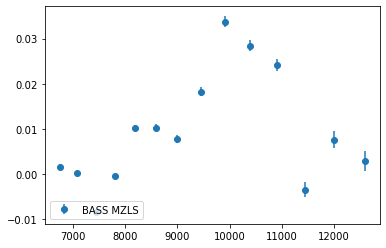

In [21]:
plt.errorbar(10**star_bins_bass_mzls, delta_mean_bass_mzls, yerr=delta_std_bass_mzls, fmt='o', color='C0', label='BASS MZLS')
plt.legend(loc='lower left');

## DECaLS only

/Users/ianharrison/opt/anaconda3/envs/pyccl/lib/python3.9/site-packages/healpy/pixelfunc.py:482: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)


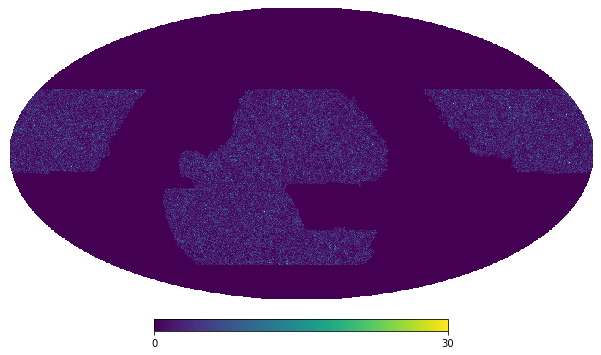

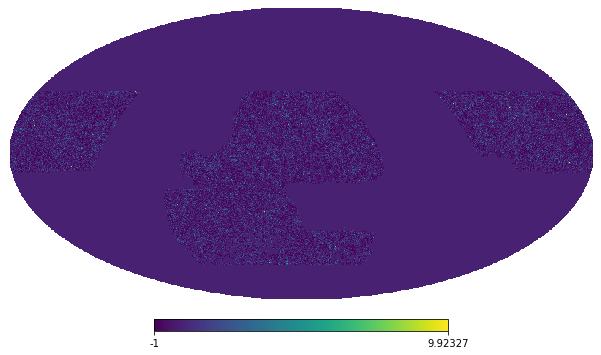

In [22]:
Nmap_decals = get_Nmap(['./data/Legacy_Survey_DECALS_galaxies-selection.fits'], decals_pixmask, nside=nside, doplot=True)
deltamap_decals = get_deltamap(Nmap_decals, decals_pixmask, decals_mask, doplot=True)

In [23]:
delta_mean_decals, delta_std_decals, star_bins_decals = get_stellar_correction(deltamap_decals, stars, np.asarray(mask, dtype=bool))

## Full DELS

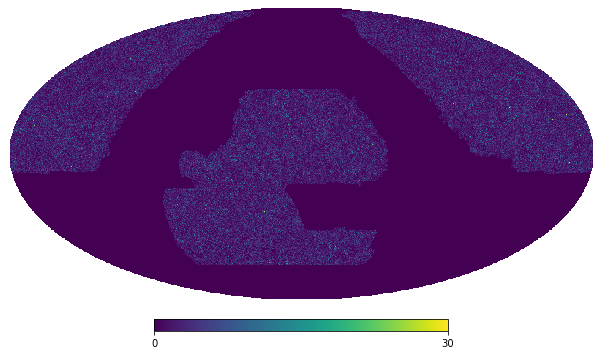

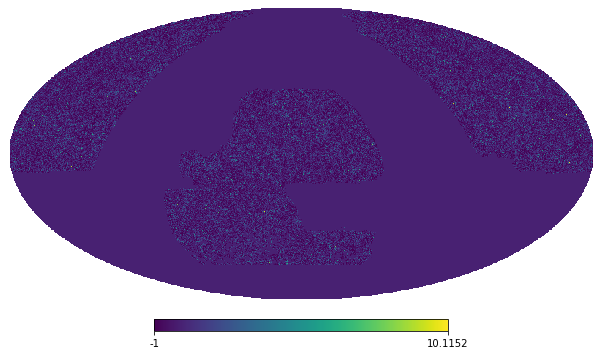

In [24]:
Nmap_dels = get_Nmap(['./data/Legacy_Survey_DECALS_galaxies-selection.fits',
                      './data/Legacy_Survey_BASS-MZLS_galaxies-selection.fits'], pixmask, nside=nside, doplot=True)
deltamap_dels = get_deltamap(Nmap_dels, pixmask, mask, doplot=True)

In [25]:
delta_mean_dels, delta_std_dels, star_bins_dels = get_stellar_correction(deltamap_dels, stars, np.asarray(mask, dtype=bool))

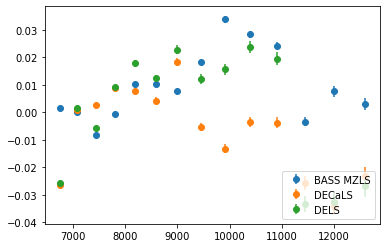

In [26]:
plt.errorbar(10**star_bins_bass_mzls, delta_mean_bass_mzls, yerr=delta_std_bass_mzls, fmt='o', color='C0', label='BASS MZLS')
plt.errorbar(10**star_bins_decals, delta_mean_decals, yerr=delta_std_decals, fmt='o', color='C1', label='DECaLS')
plt.errorbar(10**star_bins_dels, delta_mean_dels, yerr=delta_std_dels, fmt='o', color='C2', label='DELS')
plt.legend(loc='lower right');

## Uncorrected $C^{gg}_{\ell}$

In [27]:
wsp_bass_mzls = nmt.NmtWorkspace()
wsp_decals = nmt.NmtWorkspace()
wsp_dels = nmt.NmtWorkspace()

In [28]:
ellbins = nmt.NmtBin.from_nside_linear(nside, 100)

In [29]:
f_bass_mzls = nmt.NmtField(bass_mzls_apmask, [deltamap_bass_mzls])
f_decals = nmt.NmtField(decals_apmask, [deltamap_decals])
f_dels = nmt.NmtField(apmask, [deltamap_dels])

In [30]:
wsp_dels.compute_coupling_matrix(f_dels, f_dels, ellbins)

In [31]:
wsp_bass_mzls.compute_coupling_matrix(f_bass_mzls, f_bass_mzls, ellbins)

In [32]:
wsp_decals.compute_coupling_matrix(f_decals, f_decals, ellbins)

In [33]:
cl_bass_mzls_coupled = nmt.compute_coupled_cell(f_bass_mzls, f_bass_mzls)
cl_bass_mzls = wsp_bass_mzls.decouple_cell(cl_bass_mzls_coupled)

In [34]:
cl_decals_coupled = nmt.compute_coupled_cell(f_decals, f_decals)
cl_decals = wsp_decals.decouple_cell(cl_decals_coupled)

In [35]:
cl_dels_coupled = nmt.compute_coupled_cell(f_dels, f_dels)
cl_dels = wsp_dels.decouple_cell(cl_dels_coupled)

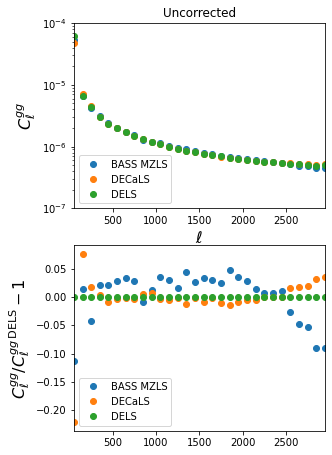

In [36]:
ell_arr = ellbins.get_effective_ells()

plt.close(1)
plt.figure(1, figsize=(4.5, 2 * 3.75))
plt.subplot(211)
plt.plot(ell_arr, cl_bass_mzls[0], 'o', color='C0', label='BASS MZLS')
plt.plot(ell_arr, cl_decals[0], 'o', color='C1', label='DECaLS')
plt.plot(ell_arr, cl_dels[0], 'o', color='C2', label='DELS')
# plt.plot(b.get_effective_ells(), Nell_dels_g+cl_gg_theory, '-', ms=1, label='Theory+SN')
# plt.loglog()
plt.yscale('log')
plt.xlim([ell_arr.min(), ell_arr.max()])
plt.ylim([1.e-7,1.e-4])
# plt.ylim([0.,1.e-5])
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell^{gg}$', fontsize=16)
plt.legend(loc='lower left')
plt.title('Uncorrected')
plt.subplot(212)
plt.plot(ell_arr, cl_bass_mzls[0]/cl_dels[0] - 1, 'o', color='C0', label='BASS MZLS')
plt.plot(ell_arr, cl_decals[0]/cl_dels[0] - 1, 'o', color='C1', label='DECaLS')
plt.plot(ell_arr, cl_dels[0]/cl_dels[0] - 1, 'o', color='C2', label='DELS')
# plt.plot(ell_arr, cl_delscomb[0], 'o', color='C3', label='DELS (comb)')
# plt.plot(b.get_effective_ells(), Nell_dels_g+cl_gg_theory, '-', ms=1, label='Theory+SN')
plt.xlim([ell_arr.min(), ell_arr.max()])
plt.ylabel('$C_\\ell^{gg} / C_\\ell^{gg \, \mathrm{DELS}} - 1$', fontsize=16)
plt.legend(loc='lower left');

## Stellar corrected $C^{gg}_{\ell}$

In [37]:
from scipy.interpolate import UnivariateSpline

def interpolate_stellar(delta_mean, delta_std, bmid, stars, mask):
    
#     params = np.polyfit(bmid, delta_mean, 5, w=1./delta_std)
#     df = np.poly1d(params)
    
    df = UnivariateSpline(bmid, delta_mean, w=1./delta_std, ext=1, k=3)
    df.set_smoothing_factor(100.0)
    
    delta_corrmap = np.zeros_like(stars)
    
    delta_corrmap[mask > 0] = df(np.log10(stars[mask > 0]))
    
    return delta_corrmap, df

In [38]:
delta_corrmap_bass_mzls, df_bass_mzls = interpolate_stellar(delta_mean_bass_mzls, delta_std_bass_mzls, star_bins_bass_mzls, stars, bass_mzls_pixmask)
delta_corrmap_decals, df_decals = interpolate_stellar(delta_mean_decals, delta_std_decals, star_bins_decals, stars, decals_pixmask)
delta_corrmap_dels, df_dels = interpolate_stellar(delta_mean_dels, delta_std_dels, star_bins_dels, stars, pixmask)

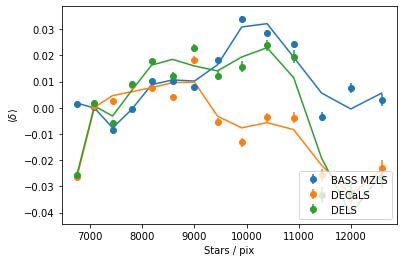

In [39]:
plt.errorbar(10**star_bins_bass_mzls, delta_mean_bass_mzls, yerr=delta_std_bass_mzls, fmt='o', color='C0', label='BASS MZLS')
plt.plot(10**star_bins_bass_mzls, df_bass_mzls(star_bins_bass_mzls), '-', c='C0')
plt.errorbar(10**star_bins_decals, delta_mean_decals, yerr=delta_std_decals, fmt='o', color='C1', label='DECaLS')
plt.plot(10**star_bins_decals, df_decals(star_bins_decals), '-', c='C1')
plt.errorbar(10**star_bins_dels, delta_mean_dels, yerr=delta_std_dels, fmt='o', color='C2', label='DELS')
plt.plot(10**star_bins_dels, df_dels(star_bins_dels), '-', c='C2')
plt.legend(loc='lower right')
plt.xlabel(r'Stars / pix')
plt.ylabel(r'$ \langle \delta \rangle $');

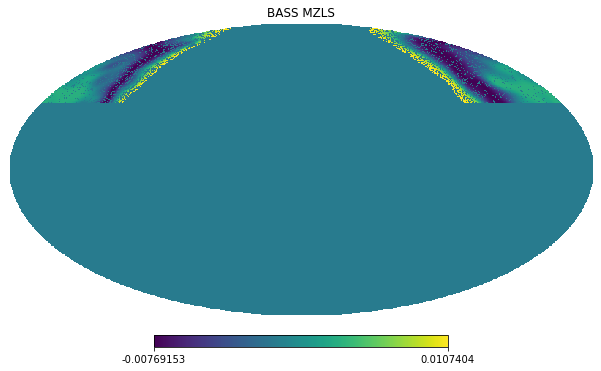

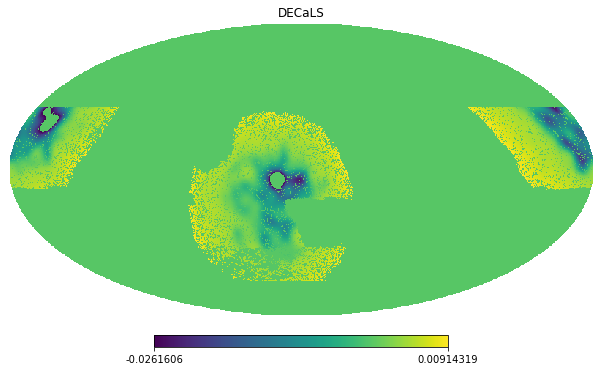

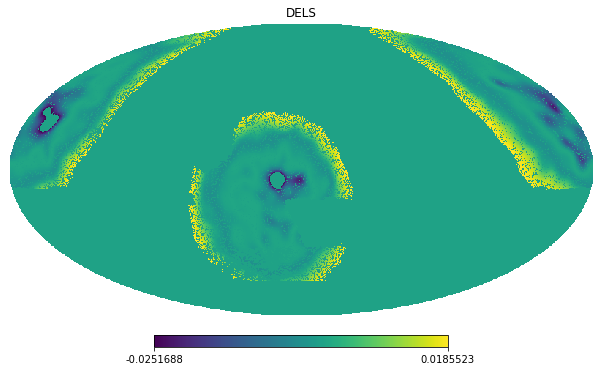

In [40]:
hp.mollview(delta_corrmap_bass_mzls, title='BASS MZLS')
hp.mollview(delta_corrmap_decals, title='DECaLS')
hp.mollview(delta_corrmap_dels, title='DELS')

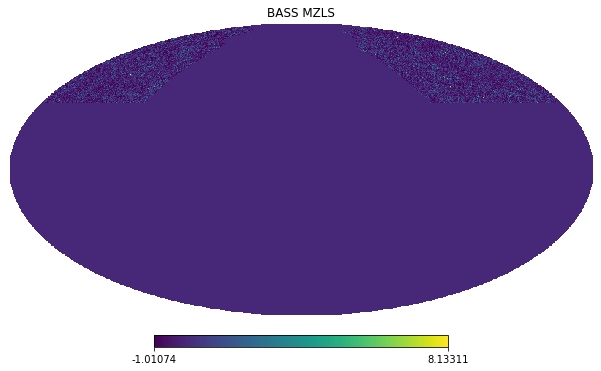

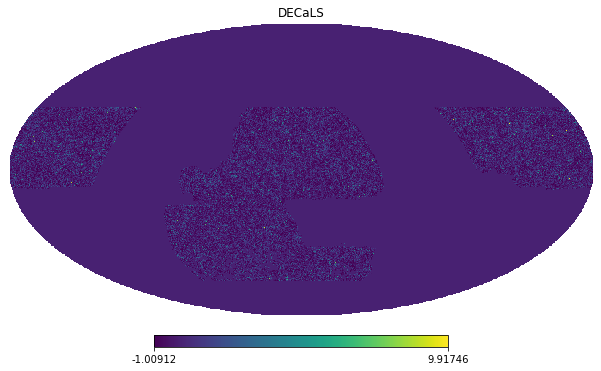

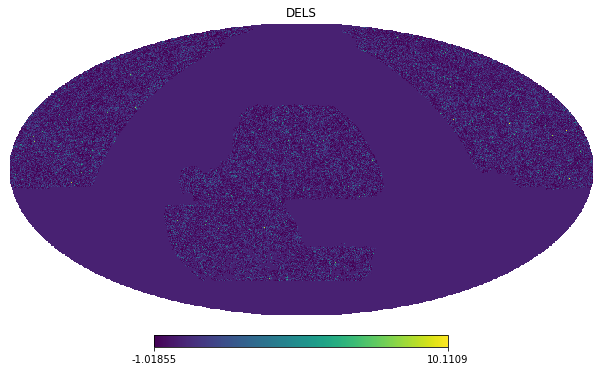

In [41]:
hp.mollview(deltamap_bass_mzls - delta_corrmap_bass_mzls, title='BASS MZLS')
hp.mollview(deltamap_decals - delta_corrmap_decals, title='DECaLS')
hp.mollview(deltamap_dels - delta_corrmap_dels, title='DELS')

In [42]:
wsp_bass_mzls = nmt.NmtWorkspace()
wsp_decals = nmt.NmtWorkspace()
wsp_dels = nmt.NmtWorkspace()
# wsp_delscomb = nmt.NmtWorkspace()

In [43]:
f_bass_mzls = nmt.NmtField(bass_mzls_apmask, [deltamap_bass_mzls - delta_corrmap_bass_mzls])
f_decals = nmt.NmtField(decals_apmask, [deltamap_decals - delta_corrmap_decals])
f_dels = nmt.NmtField(apmask, [deltamap_dels - delta_corrmap_dels])
# f_delscomb = nmt.NmtField(apmask, [deltamap_decals - delta_corrmap_decals + deltamap_bass_mzls - delta_corrmap_bass_mzls])

In [44]:
wsp_dels.compute_coupling_matrix(f_dels, f_dels, ellbins)

In [45]:
wsp_bass_mzls.compute_coupling_matrix(f_bass_mzls, f_bass_mzls, ellbins)

In [46]:
wsp_decals.compute_coupling_matrix(f_decals, f_decals, ellbins)

In [47]:
# wsp_delscomb.compute_coupling_matrix(f_delscomb, f_delscomb, ellbins)

In [48]:
cl_bass_mzls_coupled = nmt.compute_coupled_cell(f_bass_mzls, f_bass_mzls)
cl_bass_mzls = wsp_bass_mzls.decouple_cell(cl_bass_mzls_coupled)

In [49]:
cl_decals_coupled = nmt.compute_coupled_cell(f_decals, f_decals)
cl_decals = wsp_decals.decouple_cell(cl_decals_coupled)

In [50]:
cl_dels_coupled = nmt.compute_coupled_cell(f_dels, f_dels)
cl_dels = wsp_dels.decouple_cell(cl_dels_coupled)

In [51]:
# cl_delscomb_coupled = nmt.compute_coupled_cell(f_delscomb, f_delscomb)
# cl_delscomb = wsp_delscomb.decouple_cell(cl_delscomb_coupled)

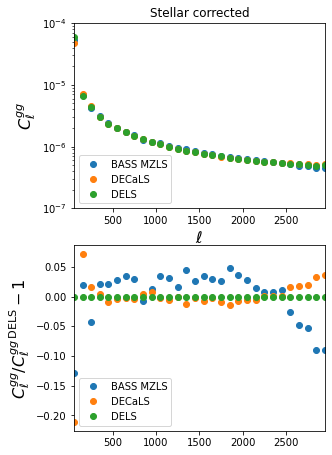

In [52]:
ell_arr = ellbins.get_effective_ells()

plt.close(1)
plt.figure(1, figsize=(4.5, 2 * 3.75))
plt.subplot(211)
plt.plot(ell_arr, cl_bass_mzls[0], 'o', color='C0', label='BASS MZLS')
plt.plot(ell_arr, cl_decals[0], 'o', color='C1', label='DECaLS')
plt.plot(ell_arr, cl_dels[0], 'o', color='C2', label='DELS')
# plt.plot(ell_arr, cl_delscomb[0], 'o', color='C3', label='DELS (comb)')
# plt.plot(b.get_effective_ells(), Nell_dels_g+cl_gg_theory, '-', ms=1, label='Theory+SN')
# plt.loglog()
plt.yscale('log')
plt.xlim([ell_arr.min(), ell_arr.max()])
plt.ylim([1.e-7,1.e-4])
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell^{gg}$', fontsize=16)
plt.legend(loc='lower left')
plt.title('Stellar corrected')
plt.subplot(212)
plt.plot(ell_arr, cl_bass_mzls[0]/cl_dels[0] - 1, 'o', color='C0', label='BASS MZLS')
plt.plot(ell_arr, cl_decals[0]/cl_dels[0] - 1, 'o', color='C1', label='DECaLS')
plt.plot(ell_arr, cl_dels[0]/cl_dels[0] - 1, 'o', color='C2', label='DELS')
# plt.plot(ell_arr, cl_delscomb[0], 'o', color='C3', label='DELS (comb)')
# plt.plot(b.get_effective_ells(), Nell_dels_g+cl_gg_theory, '-', ms=1, label='Theory+SN')
plt.xlim([ell_arr.min(), ell_arr.max()])
plt.ylabel('$C_\\ell^{gg} / C_\\ell^{gg \, \mathrm{DELS}} - 1$', fontsize=16)
plt.legend(loc='lower left');